In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np 

In [2]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    display(str.sort_values(by='Nulls', ascending=False))



In [3]:
#Function used for calculate aggregation statistics (mean, max, min, count) for numeraical variables

def agg_numeric2(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg


In [4]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [5]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
     
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns

In [6]:
# function for diminishing memory used. (optional) 
import sys

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

# Previous Application


Previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.

In [7]:
dfpreapp = pd.read_csv('C:\\Users\\kbc\\Downloads\\home-credit-default-risk\\previous_application.csv')
print(dfpreapp.shape)
dfpreapp.head()

(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


## Exploration of Dataframe

In [8]:
dfpreapp.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,1670214.0,1.923089e+06,532597.958696,1.000001e+06,1.461857e+06,1.923110e+06,2.384280e+06,2845382.000
SK_ID_CURR,1670214.0,2.783572e+05,102814.823849,1.000010e+05,1.893290e+05,2.787145e+05,3.675140e+05,456255.000
AMT_ANNUITY,1297979.0,1.595512e+04,14782.137335,0.000000e+00,6.321780e+03,1.125000e+04,2.065842e+04,418058.145
AMT_APPLICATION,1670214.0,1.752339e+05,292779.762387,0.000000e+00,1.872000e+04,7.104600e+04,1.803600e+05,6905160.000
AMT_CREDIT,1670213.0,1.961140e+05,318574.616546,0.000000e+00,2.416050e+04,8.054100e+04,2.164185e+05,6905160.000
AMT_DOWN_PAYMENT,774370.0,6.697402e+03,20921.495410,-9.000000e-01,0.000000e+00,1.638000e+03,7.740000e+03,3060045.000
AMT_GOODS_PRICE,1284699.0,2.278473e+05,315396.557937,0.000000e+00,5.084100e+04,1.123200e+05,2.340000e+05,6905160.000
HOUR_APPR_PROCESS_START,1670214.0,1.248418e+01,3.334028,0.000000e+00,1.000000e+01,1.200000e+01,1.500000e+01,23.000
NFLAG_LAST_APPL_IN_DAY,1670214.0,9.964675e-01,0.059330,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000
RATE_DOWN_PAYMENT,774370.0,7.963682e-02,0.107823,-1.497876e-05,0.000000e+00,5.160508e-02,1.089091e-01,1.000


lets run summary function to get the crucial info about the dataframe

In [ ]:
summary(dfpreapp)

Data shape: (1670214, 37)
___________________________
Data Types:
object     16
float64    15
int64       6
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
RATE_INTEREST_PRIMARY,float64,5951,149,1664263,0.0347813,1
RATE_INTEREST_PRIVILEGED,float64,5951,26,1664263,0.37315,1
AMT_DOWN_PAYMENT,float64,774370,29279,895844,-0.9,3.06004e+06
RATE_DOWN_PAYMENT,float64,774370,207034,895844,-1.49788e-05,1
NAME_TYPE_SUITE,object,849809,8,820405,NaN,NaN
DAYS_LAST_DUE,float64,997149,2874,673065,-2889,365243
DAYS_LAST_DUE_1ST_VERSION,float64,997149,4606,673065,-2801,365243
NFLAG_INSURED_ON_APPROVAL,float64,997149,3,673065,0,1
DAYS_FIRST_DRAWING,float64,997149,2839,673065,-2922,365243
DAYS_FIRST_DUE,float64,997149,2893,673065,-2892,365243


some codes to get to know the dataframe

In [9]:
dfpreapp[(dfpreapp['NAME_CONTRACT_TYPE']=='Cash loans')&(dfpreapp['AMT_DOWN_PAYMENT']==0.0)][['SK_ID_CURR','NAME_CONTRACT_TYPE','AMT_DOWN_PAYMENT']].sort_values(by='AMT_DOWN_PAYMENT')

,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_DOWN_PAYMENT
27,433469,Cash loans,0.0
1127297,297517,Cash loans,0.0
1127301,201773,Cash loans,0.0
1127431,423849,Cash loans,0.0
1127433,445082,Cash loans,0.0
...,...,...,...
564262,188813,Cash loans,0.0
564263,165766,Cash loans,0.0
564314,314831,Cash loans,0.0
564014,125636,Cash loans,0.0


function to get the unique values of categorical variables

In [10]:
def types_agg(df):
    a = dfpreapp.select_dtypes('object')
    print(a.columns)
    for i in a:
        print(i, ' --- ', dfpreapp[i].unique(), '\n')
types_agg(dfpreapp)

Index(['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION'],
      dtype='object')
NAME_CONTRACT_TYPE  ---  ['Consumer loans' 'Cash loans' 'Revolving loans' 'XNA'] 

WEEKDAY_APPR_PROCESS_START  ---  ['SATURDAY' 'THURSDAY' 'TUESDAY' 'MONDAY' 'FRIDAY' 'SUNDAY' 'WEDNESDAY'] 

FLAG_LAST_APPL_PER_CONTRACT  ---  ['Y' 'N'] 

NAME_CASH_LOAN_PURPOSE  ---  ['XAP' 'XNA' 'Repairs' 'Everyday expenses' 'Car repairs'
 'Building a house or an annex' 'Other' 'Journey'
 'Purchase of electronic equipment' 'Medicine' 'Payments on other loans'
 'Urgent needs' 'Buying a used car' 'Buying a new car'
 'Buying a holiday home / land' 'Education' 'Buying a home' 'Furniture'
 '

## Missing values

In [11]:
missing_values_table(dfpreapp)

Your selected dataframe has 37 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values
RATE_INTEREST_PRIMARY,1664263,99.6
RATE_INTEREST_PRIVILEGED,1664263,99.6
AMT_DOWN_PAYMENT,895844,53.6
RATE_DOWN_PAYMENT,895844,53.6
NAME_TYPE_SUITE,820405,49.1
DAYS_FIRST_DRAWING,673065,40.3
DAYS_FIRST_DUE,673065,40.3
DAYS_LAST_DUE_1ST_VERSION,673065,40.3
DAYS_LAST_DUE,673065,40.3
DAYS_TERMINATION,673065,40.3


<AxesSubplot:>

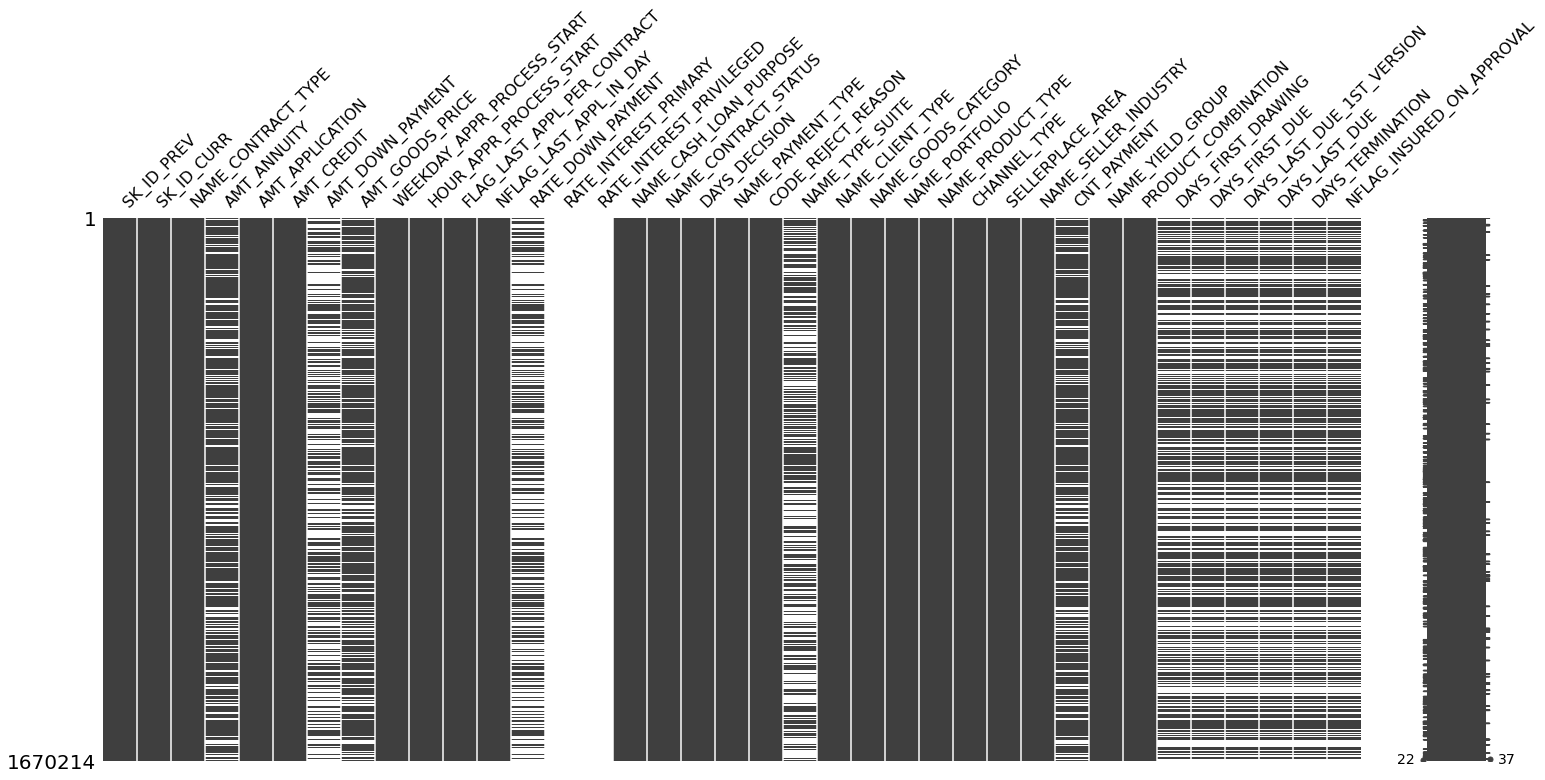

In [12]:
import missingno as msno
%matplotlib inline
msno.matrix(dfpreapp)

from the table, it can be concluded that first 2 features have a high rate of missing values and they can be dropped from the data.
We see there are a number of columns with a high percentage of missing values. There is no well-established threshold 
for removing missing values, and the best course of action depends on the problem. Here, to reduce the number of features,
we will remove any columns in either the training or the testing data that have greater than 90% missing values
Since more than 90% of data are missing in RATE_INTEREST_PRIMARY and RATE_INTEREST_PRIVILEGED columns, we drop them.

In [13]:
dfpreapp = dfpreapp.drop(['RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED'], 1)

In [14]:
# Those values seems outliers. So we replace '365243' with nan in some columns
dfpreapp['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
dfpreapp['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
dfpreapp['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
dfpreapp['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
dfpreapp['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

## Feature Generation

In [15]:
# new features 
dfpreapp['APPLICATION_CREDIT_DIFF'] = dfpreapp['AMT_APPLICATION'] - dfpreapp['AMT_CREDIT']
dfpreapp['APPLICATION_CREDIT_RATIO'] = dfpreapp['AMT_APPLICATION'] / dfpreapp['AMT_CREDIT']
dfpreapp['CREDIT_TO_ANNUITY_RATIO'] = dfpreapp['AMT_CREDIT']/dfpreapp['AMT_ANNUITY']
dfpreapp['DOWN_PAYMENT_TO_CREDIT'] = dfpreapp['AMT_DOWN_PAYMENT'] / dfpreapp['AMT_CREDIT']

In [16]:
dfpreapp = convert_types(dfpreapp, print_info=True)

Original Memory Usage: 0.52 gb.
New Memory Usage: 0.2 gb.


In [21]:
# Convert the numeric variable into aggregated form (count, mean, max, min, sum). and we have new features. 

dfpreapp_num = agg_numeric2(dfpreapp, 'SK_ID_CURR', 'preapp')
dfpreapp_num

<ipython-input-3-2b31ed5e2fb4>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df[group_var] = group_ids


,SK_ID_CURR,preapp_AMT_ANNUITY_count,preapp_AMT_ANNUITY_mean,preapp_AMT_ANNUITY_max,preapp_AMT_ANNUITY_min,preapp_AMT_ANNUITY_sum,preapp_AMT_APPLICATION_count,preapp_AMT_APPLICATION_mean,preapp_AMT_APPLICATION_max,preapp_AMT_APPLICATION_min,...,preapp_CREDIT_TO_ANNUITY_RATIO_count,preapp_CREDIT_TO_ANNUITY_RATIO_mean,preapp_CREDIT_TO_ANNUITY_RATIO_max,preapp_CREDIT_TO_ANNUITY_RATIO_min,preapp_CREDIT_TO_ANNUITY_RATIO_sum,preapp_DOWN_PAYMENT_TO_CREDIT_count,preapp_DOWN_PAYMENT_TO_CREDIT_mean,preapp_DOWN_PAYMENT_TO_CREDIT_max,preapp_DOWN_PAYMENT_TO_CREDIT_min,preapp_DOWN_PAYMENT_TO_CREDIT_sum
0,100001,1,3951.000000,3951.000000,3951.000000,3951.000000,1,24835.500,24835.5,24835.5,...,1,6.020501,6.020501,6.020501,6.020501,1,0.105940,0.105940,0.105940,0.105940
1,100002,1,9251.775391,9251.775391,9251.775391,9251.775391,1,179055.000,179055.0,179055.0,...,1,19.353584,19.353584,19.353584,19.353584,1,0.000000,0.000000,0.000000,0.000000
2,100003,3,56553.988281,98356.992188,6737.310059,169661.968750,3,435436.500,900000.0,68809.5,...,3,8.677473,10.531859,5.399568,26.032417,2,0.050585,0.101170,0.000000,0.101170
3,100004,1,5357.250000,5357.250000,5357.250000,5357.250000,1,24282.000,24282.0,24282.0,...,1,3.753045,3.753045,3.753045,3.753045,1,0.241719,0.241719,0.241719,0.241719
4,100005,1,4813.200195,4813.200195,4813.200195,4813.200195,2,22308.750,44617.5,0.0,...,1,8.342371,8.342371,8.342371,8.342371,1,0.111173,0.111173,0.111173,0.111173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,1,6605.910156,6605.910156,6605.910156,6605.910156,1,40455.000,40455.0,40455.0,...,1,6.124062,6.124062,6.124062,6.124062,1,0.000000,0.000000,0.000000,0.000000
338853,456252,1,10074.464844,10074.464844,10074.464844,10074.464844,1,57595.500,57595.5,57595.5,...,1,5.640151,5.640151,5.640151,5.640151,1,0.060822,0.060822,0.060822,0.060822
338854,456253,2,4770.404785,5567.714844,3973.094971,9540.809570,2,24162.750,28912.5,19413.0,...,2,4.207165,4.904346,3.509984,8.414330,2,0.264987,0.424008,0.105966,0.529973
338855,456254,2,10681.131836,19065.824219,2296.439941,21362.263672,2,121317.750,223789.5,18846.0,...,2,11.160244,12.977330,9.343157,22.320488,2,0.000000,0.000000,0.000000,0.000000


Convert categoric variables into dummies with 'agg_categorical' function

In [17]:
dfpreapp_categ = agg_categorical(dfpreapp, 'SK_ID_CURR', 'preapp')
dfpreapp_categ

,preapp_NAME_GOODS_CATEGORY_Animals_mean,preapp_NAME_GOODS_CATEGORY_Animals_sum,preapp_NAME_GOODS_CATEGORY_House Construction_mean,preapp_NAME_GOODS_CATEGORY_House Construction_sum,preapp_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,preapp_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,preapp_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,preapp_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,preapp_NAME_CASH_LOAN_PURPOSE_Hobby_mean,preapp_NAME_CASH_LOAN_PURPOSE_Hobby_sum,...,preapp_CODE_REJECT_REASON_XAP_mean,preapp_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,preapp_NAME_PORTFOLIO_POS_sum,preapp_NAME_CONTRACT_TYPE_Consumer loans_sum,preapp_NAME_CASH_LOAN_PURPOSE_XAP_sum,preapp_NAME_PRODUCT_TYPE_XNA_sum,preapp_NAME_CONTRACT_STATUS_Approved_sum,preapp_CODE_REJECT_REASON_XAP_sum,preapp_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,preapp_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.00,1.0,1,1,1,1,1,1,1,1
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.00,1.0,1,1,1,1,1,1,1,1
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.00,1.0,2,2,2,2,3,3,3,3
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.00,1.0,1,1,1,1,1,1,1,1
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.00,1.0,1,1,1,2,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.00,1.0,1,1,1,1,1,1,1,1
456252,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.00,1.0,1,1,1,1,1,1,1,1
456253,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.00,1.0,2,2,2,2,2,2,2,2


new feature to the previous application data

In [18]:
prev_apps_count = dfpreapp[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
dfpreapp['SK_ID_PREV'] = dfpreapp['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

merge numeric and categoric dataframe into one file

In [22]:
dfpreapplast = pd.merge(dfpreapp_categ, dfpreapp_num, how='left', on="SK_ID_CURR")

In [23]:
summary(dfpreapplast)

Data shape: (338857, 386)
___________________________
Data Types:
float64    145
uint8      142
float32     68
int64       31
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
preapp_DAYS_FIRST_DRAWING_min,float32,62503,2838,276354,-2922.0,-2.0
preapp_DAYS_FIRST_DRAWING_mean,float32,62503,2922,276354,-2922.0,-2.0
preapp_DAYS_FIRST_DRAWING_max,float32,62503,2837,276354,-2922.0,-2.0
preapp_DAYS_TERMINATION_mean,float32,311580,25805,27277,-2852.0,-2.0
preapp_DAYS_TERMINATION_min,float32,311580,2830,27277,-2874.0,-2.0
...,...,...,...,...,...,...
preapp_NAME_CASH_LOAN_PURPOSE_Medicine_sum,uint8,338857,10,0,0.0,12.0
preapp_NAME_CASH_LOAN_PURPOSE_Medicine_mean,float64,338857,86,0,0.0,1.0
preapp_NAME_CASH_LOAN_PURPOSE_Journey_sum,uint8,338857,7,0,0.0,6.0
preapp_NAME_CASH_LOAN_PURPOSE_Journey_mean,float64,338857,73,0,0.0,1.0


## Converting data types 

In [24]:
dfpreapplast = convert_types(dfpreapplast, print_info=True)
dfpreapplast

Original Memory Usage: 0.62 gb.
New Memory Usage: 0.42 gb.


,SK_ID_CURR,preapp_NAME_GOODS_CATEGORY_Animals_mean,preapp_NAME_GOODS_CATEGORY_Animals_sum,preapp_NAME_GOODS_CATEGORY_House Construction_mean,preapp_NAME_GOODS_CATEGORY_House Construction_sum,preapp_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,preapp_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,preapp_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,preapp_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,preapp_NAME_CASH_LOAN_PURPOSE_Hobby_mean,...,preapp_CREDIT_TO_ANNUITY_RATIO_count,preapp_CREDIT_TO_ANNUITY_RATIO_mean,preapp_CREDIT_TO_ANNUITY_RATIO_max,preapp_CREDIT_TO_ANNUITY_RATIO_min,preapp_CREDIT_TO_ANNUITY_RATIO_sum,preapp_DOWN_PAYMENT_TO_CREDIT_count,preapp_DOWN_PAYMENT_TO_CREDIT_mean,preapp_DOWN_PAYMENT_TO_CREDIT_max,preapp_DOWN_PAYMENT_TO_CREDIT_min,preapp_DOWN_PAYMENT_TO_CREDIT_sum
0,100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,1,6.020501,6.020501,6.020501,6.020501,1,0.105940,0.105940,0.105940,0.105940
1,100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,1,19.353584,19.353584,19.353584,19.353584,1,0.000000,0.000000,0.000000,0.000000
2,100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,3,8.677473,10.531859,5.399568,26.032417,2,0.050585,0.101170,0.000000,0.101170
3,100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,1,3.753045,3.753045,3.753045,3.753045,1,0.241719,0.241719,0.241719,0.241719
4,100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,1,8.342371,8.342371,8.342371,8.342371,1,0.111173,0.111173,0.111173,0.111173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,1,6.124062,6.124062,6.124062,6.124062,1,0.000000,0.000000,0.000000,0.000000
338853,456252,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,1,5.640151,5.640151,5.640151,5.640151,1,0.060822,0.060822,0.060822,0.060822
338854,456253,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,2,4.207165,4.904346,3.509984,8.414330,2,0.264987,0.424008,0.105966,0.529973
338855,456254,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,2,11.160244,12.977330,9.343157,22.320488,2,0.000000,0.000000,0.000000,0.000000


## Saving new file

In [ ]:
dfpreapplast.to_csv('/content/drive/MyDrive/home-credit-default-risk/dfpreapplast_ready.csv')